In [ ]:
import torch
import gym
import matplotlib.pyplot as plt
import numpy as np 
from collections import deque

In [ ]:
lr = 0.005
γ = 0.9999
NUM_EPISODES = 1000
SCORE_HISTORY = []
SCORE_HISTORY_BUFFER = deque([0.0], maxlen=100)
SCORE_HISTORY_MEAN = []
I = 1

env = gym.make('CartPole-v1')

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, env.action_space.n),
    torch.nn.Softmax(dim=-1)
)

optim = torch.optim.Adam(net.parameters(), lr=lr)

In [ ]:
for i in range(NUM_EPISODES):
    state = torch.tensor(env.reset(), dtype=torch.float)    
    done = False
    Actions, States, Rewards = [], [], []
    score = 0

    while not done:
        probs = net(state)                                                      # two values ranging from 0 to 1. For example, we get: tensor([0.9702, 0.0298], grad_fn=<SoftmaxBackward0>)
        dist = torch.distributions.Categorical(probs=probs)     
        action = dist.sample().item()
        next_state, reward, done, _ = env.step(action)
        
        Actions.append(torch.tensor(action, dtype=torch.int))
        States.append(state)
        Rewards.append(reward)

        state = torch.tensor(next_state, dtype=torch.float)
        score = score + reward
    
    # Calculate G_t
    DiscountedReturns = []
    for t in range(len(Rewards)):
        G = 0.0
        for idx, R in enumerate(Rewards[t:]):
            G = G + (γ**idx)*R
        DiscountedReturns.append(G)
    
    # Update theta
    for State, Action, G in zip(States, Actions, DiscountedReturns):
        probs = net(State)
        dist = torch.distributions.Categorical(probs=probs)    
        log_prob = dist.log_prob(Action)                                        # calculate log probability (i.e. ln p(a_t|s_t))
        
        loss = -log_prob * G * I
        
        optim.zero_grad()
        loss.backward()
        optim.step()

    I = I * γ
    SCORE_HISTORY.append(score)
    SCORE_HISTORY_BUFFER.append(score)
    SCORE_HISTORY_MEAN.append(np.mean(SCORE_HISTORY_BUFFER))

    if i % 100 == 0:
        print(f'epsiode: {i}, score: {score}, score of last 100 episodes: {np.mean(SCORE_HISTORY_BUFFER)}')

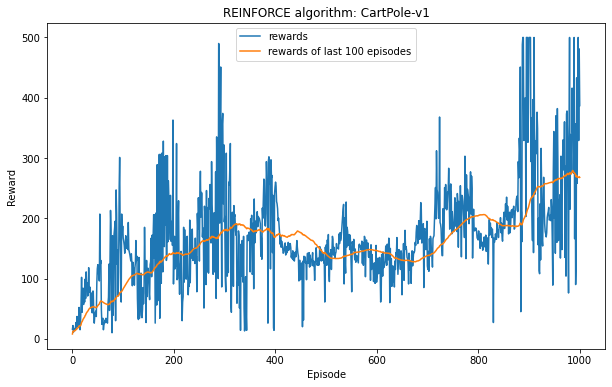

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

x = np.linspace(0, NUM_EPISODES, NUM_EPISODES)

ax.plot(x, SCORE_HISTORY, label='rewards')
ax.plot(x, SCORE_HISTORY_MEAN, label='rewards of lastest 100 episodes')

ax.set_xlabel("Episode")
ax.set_ylabel("Reward")
ax.set_title("REINFORCE algorithm: CartPole-v1")
ax.legend()